In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lazypredict.Supervised import LazyClassifier

# Set random seed for reproducibility
np.random.seed(42)

# Load the German Credit dataset from UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
column_names = [
    'status', 'duration', 'credit_history', 'purpose', 'amount', 'savings', 'employment_duration',
    'installment_rate', 'personal_status_sex', 'other_debtors', 'present_residence', 'property',
    'age', 'other_installment_plans', 'housing', 'number_credits', 'job', 'people_liable',
    'telephone', 'foreign_worker', 'credit_risk'
]

data = pd.read_csv(url, sep=' ', header=None, names=column_names)

# Convert target to binary (1=Good, 2=Bad in the original dataset)
data['credit_risk'] = data['credit_risk'].map({1: 0, 2: 1})  # 0=Good, 1=Bad

print("Dataset shape:", data.shape)
print("\nFirst few rows:")
data.head()

In [ ]:
# 1. data shape
print(f"Dataset Shape: {data.shape}")
print(f"Dataset Info: {data.info()}")

# 2. Check for missing values
print(f"Missing Values: {data.isnull().sum()}")

Target Distribution:
credit_risk
0    700
1    300
Name: count, dtype: int64
credit_risk
0    70.00%
1    30.00%
Name: proportion, dtype: object


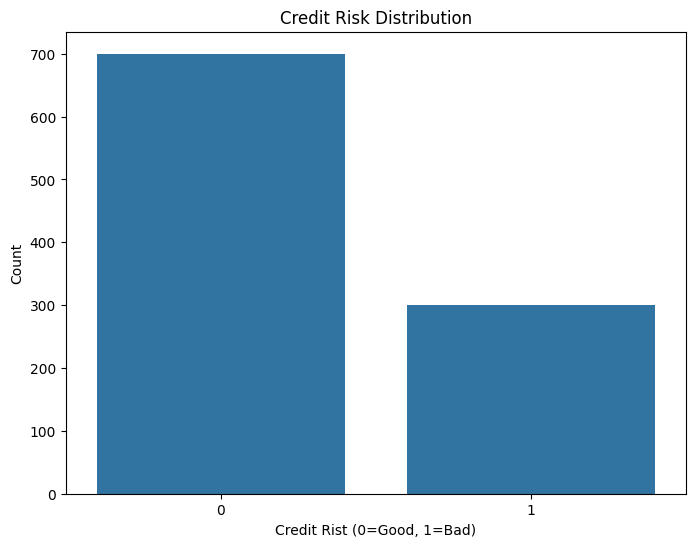

In [4]:
# Target Distribution
print(f"Target Distribution:")
print(data['credit_risk'].value_counts())
print(data['credit_risk'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

# Visualize target distribution
plt.figure(figsize=(8,6))
sns.countplot(x='credit_risk', data=data)
plt.title('Credit Risk Distribution')
plt.xlabel('Credit Rist (0=Good, 1=Bad)')
plt.ylabel('Count')
plt.show()

Categorical feature:, ['status', 'credit_history', 'purpose', 'savings', 'employment_duration', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']
Numerical_features:, ['duration', 'amount', 'installment_rate', 'present_residence', 'age', 'number_credits', 'people_liable']


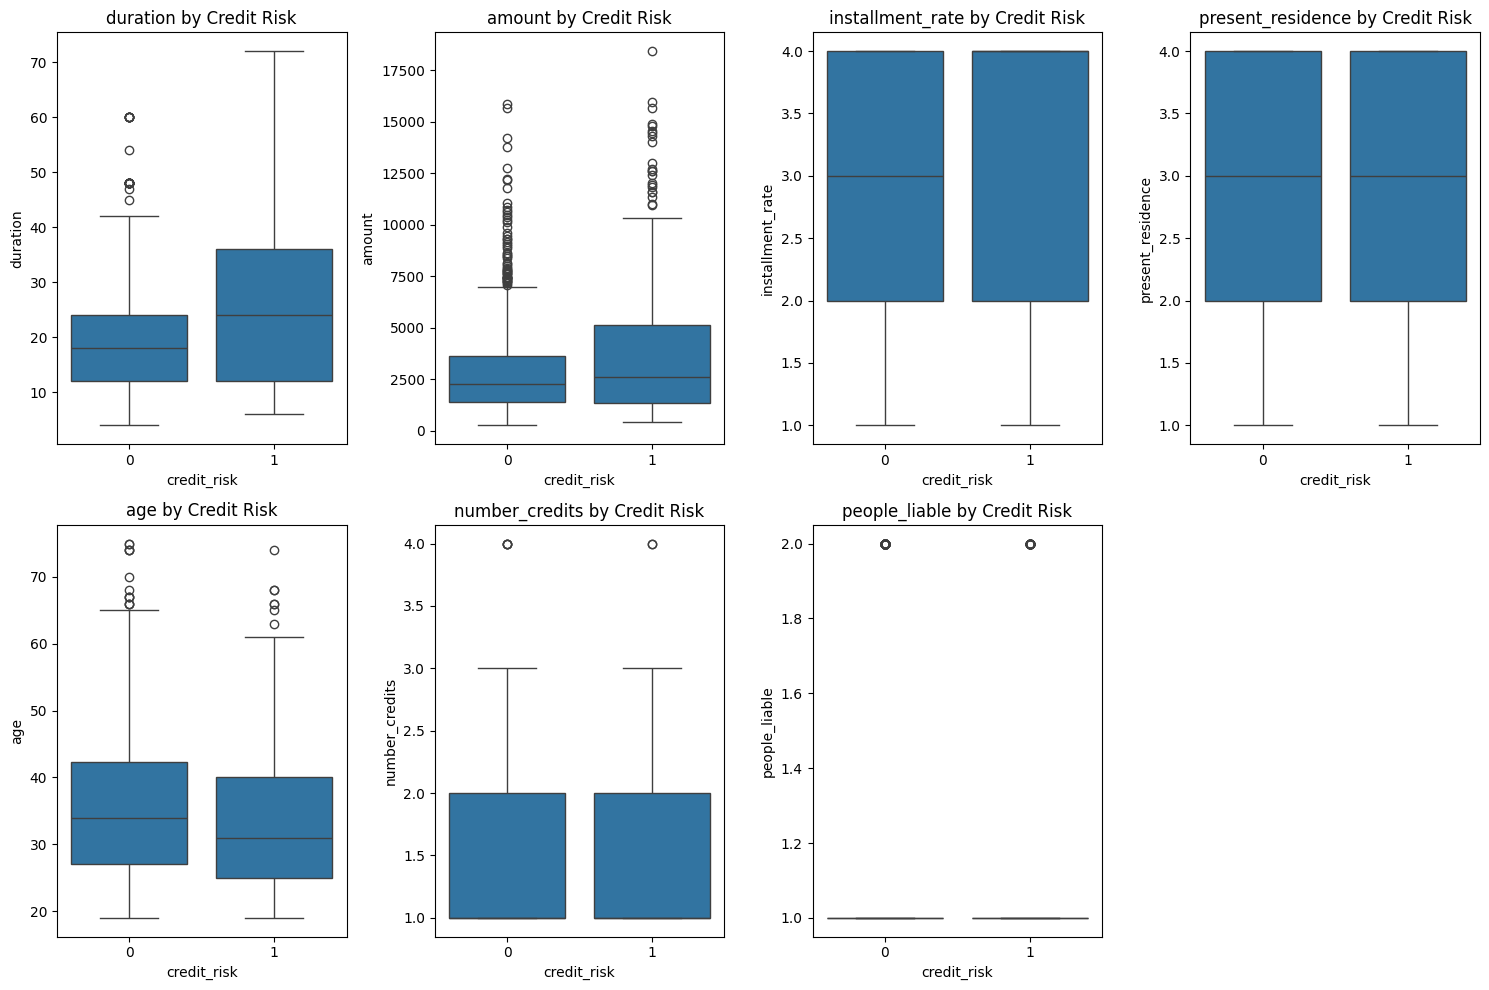

In [8]:
cat_features = data.select_dtypes(include=['object']).columns.tolist()
num_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_features.remove('credit_risk') # remove target from features list

print(f"Categorical feature:, {cat_features}")
print(f"Numerical_features:, {num_features}")

# Explore numerical features
plt.figure(figsize=(15,10))
for i, feature in enumerate(num_features[:8]):
    plt.subplot(2,4,i+1)
    sns.boxplot(x='credit_risk', y= feature, data=data)
    plt.title(f'{feature} by Credit Risk')
plt.tight_layout()
plt.show()



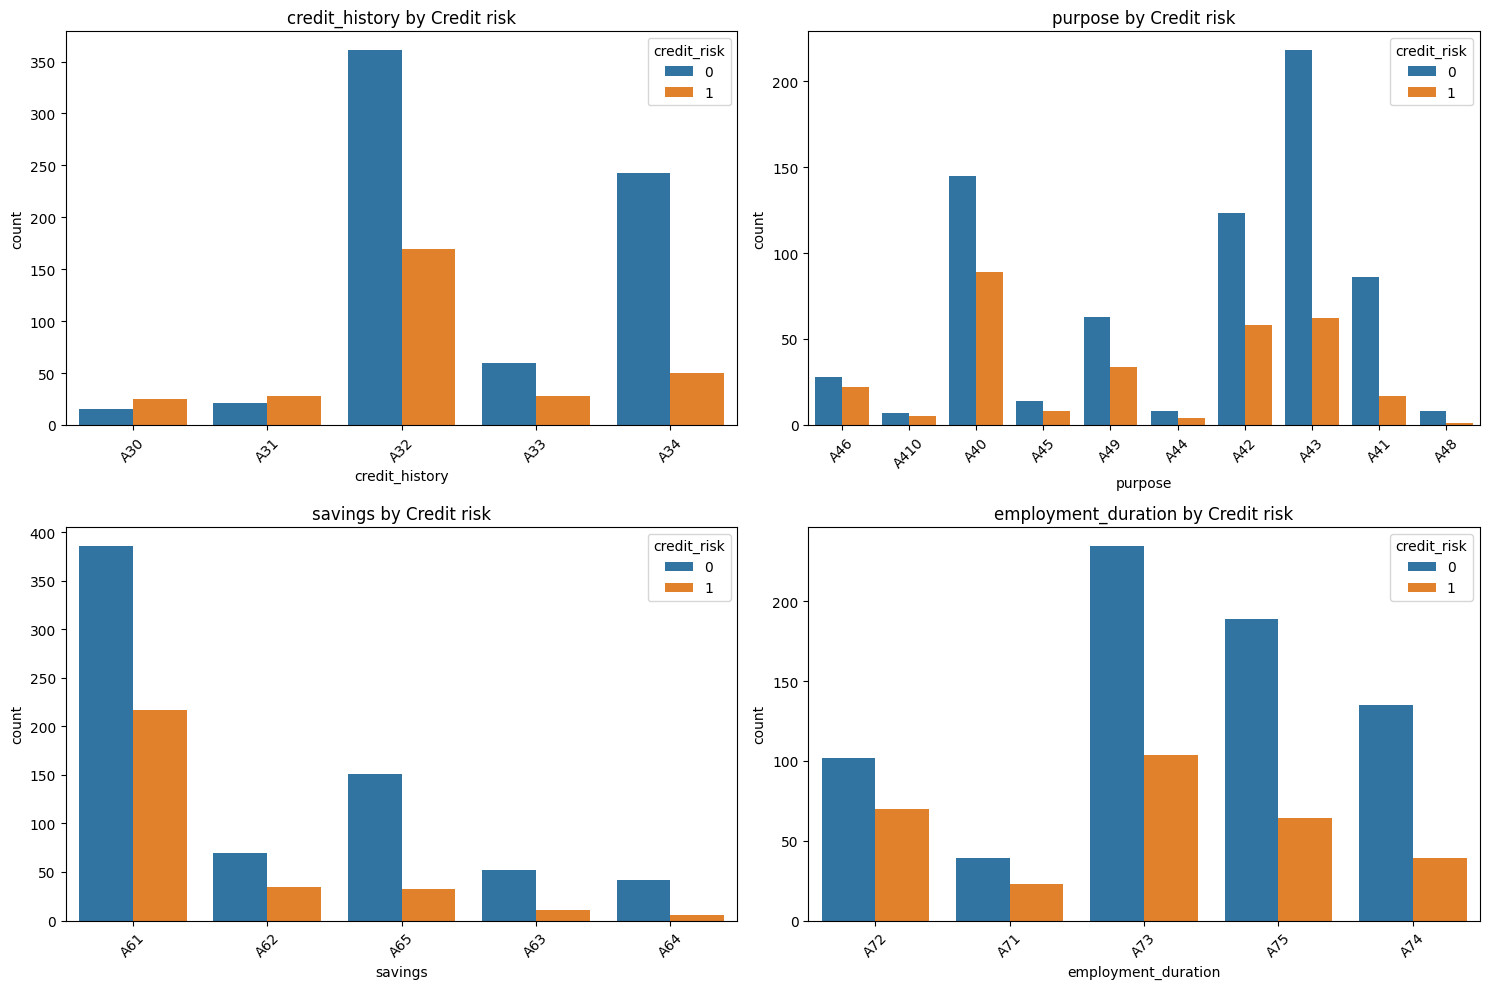

In [9]:
# Explore Categorical features
important_cat_features = ['credit_history', 'purpose', 'savings', 'employment_duration']
plt.figure(figsize=(15,10))
for i, feature in enumerate(important_cat_features):
    plt.subplot(2,2,i+1)
    order  = data.groupby(feature)['credit_risk'].mean().sort_values(ascending=False).index
    sns.countplot(x=feature, hue='credit_risk', data=data, order=order)
    plt.title(f'{feature} by Credit risk')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Calculate default rate by feature (for selected categorical features)
for feature in important_cat_features:
    default_rate = data.groupby(feature)['credit_risk'].mean().sort_values(ascending=False)
    print(f"\nDefault Rate by {feature}:")
    print(default_rate)


Default Rate by credit_history:
credit_history
A30   0.62
A31   0.57
A32   0.32
A33   0.32
A34   0.17
Name: credit_risk, dtype: float64

Default Rate by purpose:
purpose
A46    0.44
A410   0.42
A40    0.38
A45    0.36
A49    0.35
A44    0.33
A42    0.32
A43    0.22
A41    0.17
A48    0.11
Name: credit_risk, dtype: float64

Default Rate by savings:
savings
A61   0.36
A62   0.33
A65   0.17
A63   0.17
A64   0.12
Name: credit_risk, dtype: float64

Default Rate by employment_duration:
employment_duration
A72   0.41
A71   0.37
A73   0.31
A75   0.25
A74   0.22
Name: credit_risk, dtype: float64


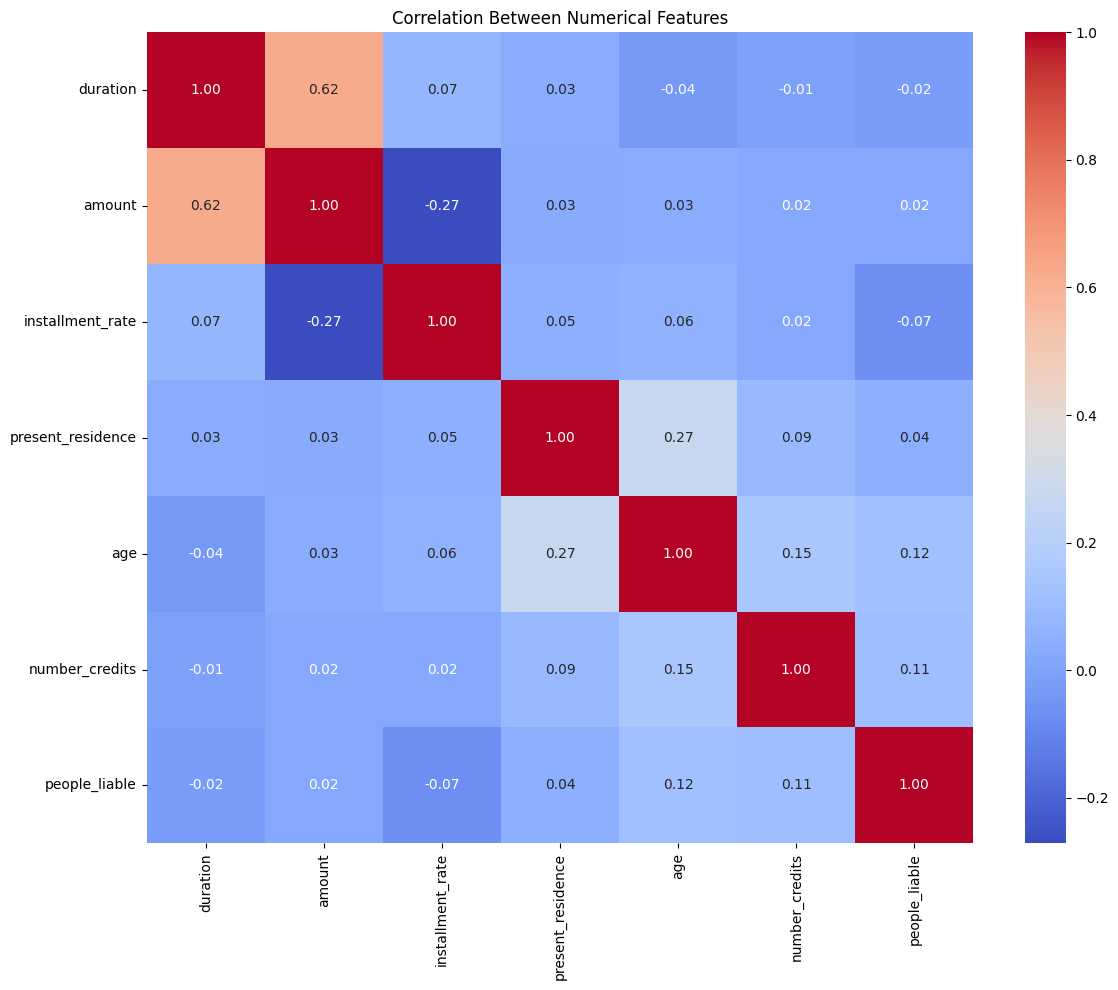

,duration,amount,installment_rate,present_residence,age,number_credits,people_liable
duration,1.00,0.62,0.07,0.03,-0.04,-0.01,-0.02
amount,0.62,1.00,-0.27,0.03,0.03,0.02,0.02
installment_rate,0.07,-0.27,1.00,0.05,0.06,0.02,-0.07
present_residence,0.03,0.03,0.05,1.00,0.27,0.09,0.04
age,-0.04,0.03,0.06,0.27,1.00,0.15,0.12
number_credits,-0.01,0.02,0.02,0.09,0.15,1.00,0.11
people_liable,-0.02,0.02,-0.07,0.04,0.12,0.11,1.00


In [12]:
# Correlation between numerical features
plt.figure(figsize=(12, 10))
corr = data[num_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Numerical Features')
plt.tight_layout()
plt.show()
display(corr)

In [13]:
# Prepare data for modeling
X = data.drop('credit_risk', axis=1)
y = data['credit_risk']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define categorical and numerical features for preprocessing
categorical_features = ['status', 'credit_history', 'purpose', 'savings', 'employment_duration', 
                       'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 
                       'housing', 'job', 'telephone', 'foreign_worker']
numerical_features = ['duration', 'amount', 'installment_rate', 'present_residence', 
                     'age', 'number_credits', 'people_liable']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Process the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed training data shape:", X_train_processed.shape)
print("Processed testing data shape:", X_test_processed.shape)

Processed training data shape: (800, 48)
Processed testing data shape: (200, 48)


In [14]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_processed, X_test_processed, y_train, y_test)
print("Model Comparison:")
print(models)

 97%|█████████▋| 31/32 [00:00<00:00, 30.14it/s]

[LightGBM] [Info] Number of positive: 240, number of negative: 560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 457
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

100%|██████████| 32/32 [00:01<00:00, 22.10it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model Comparison:
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
QuadraticDiscriminantAnalysis      0.76               0.73     0.73      0.76   
LogisticRegression                 0.79               0.73     0.73      0.78   
LinearDiscriminantAnalysis         0.78               0.72     0.72      0.78   
LinearSVC                          0.78             

Tuning Logistic Regression...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sandeepsony/Projects/PandasPrep/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_rati

Best Logistic Regression Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
Best ROC AUC: 0.7765252976190475

Tuning Quadratic Discriminant Analysis...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best QDA Parameters: {'reg_param': 0.1, 'store_covariance': True}
Best ROC AUC: 0.7777157738095238

--- Logistic Regression Evaluation ---
Test ROC AUC: 0.8049
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       140
           1       0.52      0.77      0.62        60

    accuracy                           0.71       200
   macro avg       0.70      0.73      0.70       200
weighted avg       0.77      0.71      0.73       200


--- QDA Evaluation ---
Test ROC AUC: 0.7927
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       140
           1       0.63      0.52      0.57        60

    accuracy                

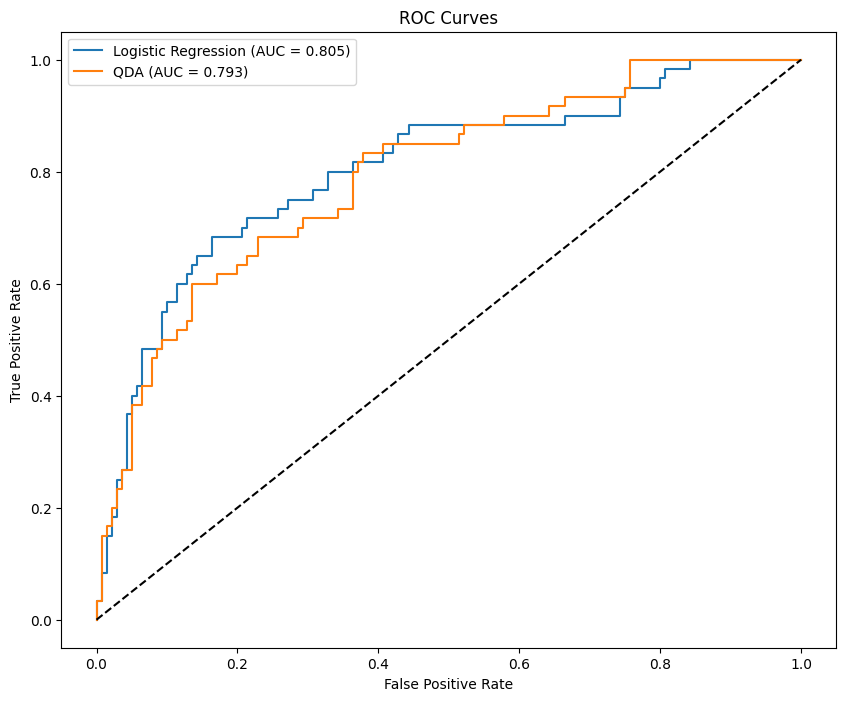

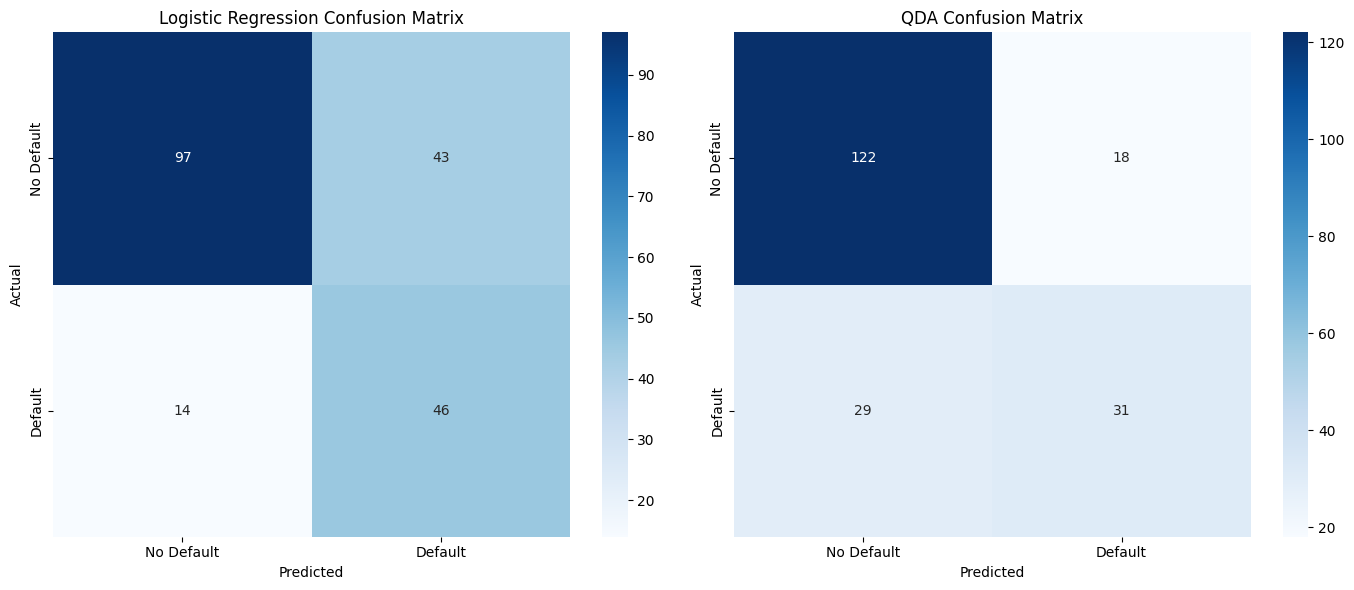


Logistic Regression is the best model


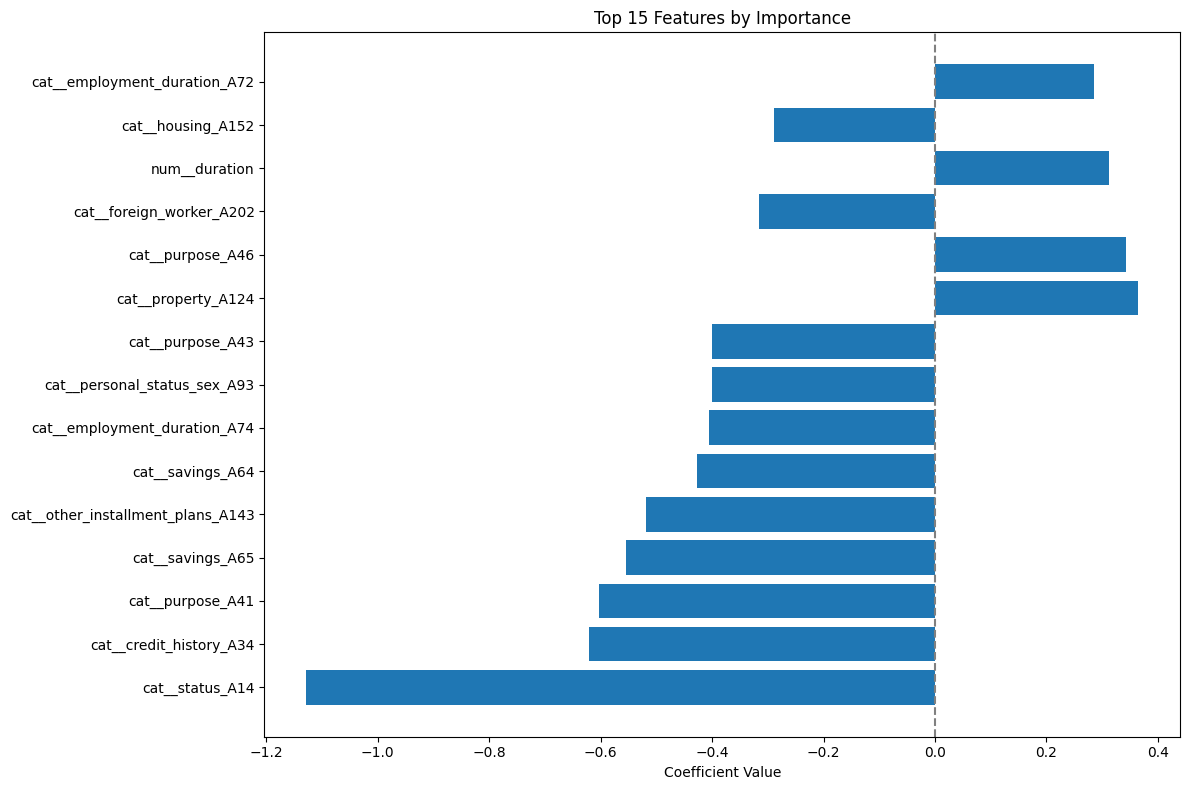

In [15]:
# Logistic Regression & QDA
# Import necessary libraries for model tuning
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve

# 1. Tuning Logistic Regression
# Define parameter grid
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'class_weight': [None, 'balanced']
}

# Some parameter combinations are incompatible, so we'll use a simpler grid
simplified_param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', None],
    'class_weight': [None, 'balanced']
}

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create grid search with cross-validation
lr_grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid=simplified_param_grid_lr,
    cv=cv,
    scoring='roc_auc',  # Using ROC AUC as our primary metric
    n_jobs=-1,
    verbose=1
)

# Fit grid search to training data
print("Tuning Logistic Regression...")
lr_grid_search.fit(X_train_processed, y_train)

# Get the best parameters and results
print("Best Logistic Regression Parameters:", lr_grid_search.best_params_)
print("Best ROC AUC:", lr_grid_search.best_score_)

# Get the best model
best_lr = lr_grid_search.best_estimator_

# 2. Tuning QuadraticDiscriminantAnalysis
# QDA has fewer parameters to tune
param_grid_qda = {
    'reg_param': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],  # Regularization parameter
    'store_covariance': [True, False]
}

# Create grid search for QDA
qda_grid_search = GridSearchCV(
    QuadraticDiscriminantAnalysis(),
    param_grid=param_grid_qda,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit grid search to training data
print("\nTuning Quadratic Discriminant Analysis...")
qda_grid_search.fit(X_train_processed, y_train)

# Get the best parameters and results
print("Best QDA Parameters:", qda_grid_search.best_params_)
print("Best ROC AUC:", qda_grid_search.best_score_)

# Get the best model
best_qda = qda_grid_search.best_estimator_

# 3. Evaluate both models on the test set
# Predictions for Logistic Regression
lr_y_pred = best_lr.predict(X_test_processed)
lr_y_pred_proba = best_lr.predict_proba(X_test_processed)[:, 1]
lr_test_auc = roc_auc_score(y_test, lr_y_pred_proba)

# Predictions for QDA
qda_y_pred = best_qda.predict(X_test_processed)
qda_y_pred_proba = best_qda.predict_proba(X_test_processed)[:, 1]
qda_test_auc = roc_auc_score(y_test, qda_y_pred_proba)

# Print results
print("\n--- Logistic Regression Evaluation ---")
print(f"Test ROC AUC: {lr_test_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, lr_y_pred))

print("\n--- QDA Evaluation ---")
print(f"Test ROC AUC: {qda_test_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, qda_y_pred))

# 4. Plot ROC curves for both models
plt.figure(figsize=(10, 8))
# LR ROC
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_y_pred_proba)
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_test_auc:.3f})')

# QDA ROC
qda_fpr, qda_tpr, _ = roc_curve(y_test, qda_y_pred_proba)
plt.plot(qda_fpr, qda_tpr, label=f'QDA (AUC = {qda_test_auc:.3f})')

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# 5. Confusion matrices
plt.figure(figsize=(14, 6))

# LR confusion matrix
plt.subplot(1, 2, 1)
lr_cm = confusion_matrix(y_test, lr_y_pred)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# QDA confusion matrix
plt.subplot(1, 2, 2)
qda_cm = confusion_matrix(y_test, qda_y_pred)
sns.heatmap(qda_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title('QDA Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# 6. For the best model, examine feature importance (if it's Logistic Regression)
if lr_test_auc > qda_test_auc:
    best_model = best_lr
    print("\nLogistic Regression is the best model")
    
    # Get feature names from the preprocessor
    feature_names = preprocessor.get_feature_names_out()
    
    # Get coefficients
    coefficients = best_lr.coef_[0]
    
    # Create a DataFrame for visualization
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })
    
    # Sort by absolute coefficient value
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False).head(15)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(coef_df['Feature'], coef_df['Coefficient'])
    plt.xlabel('Coefficient Value')
    plt.title('Top 15 Features by Importance')
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    best_model = best_qda
    print("\nQuadratic Discriminant Analysis is the best model")


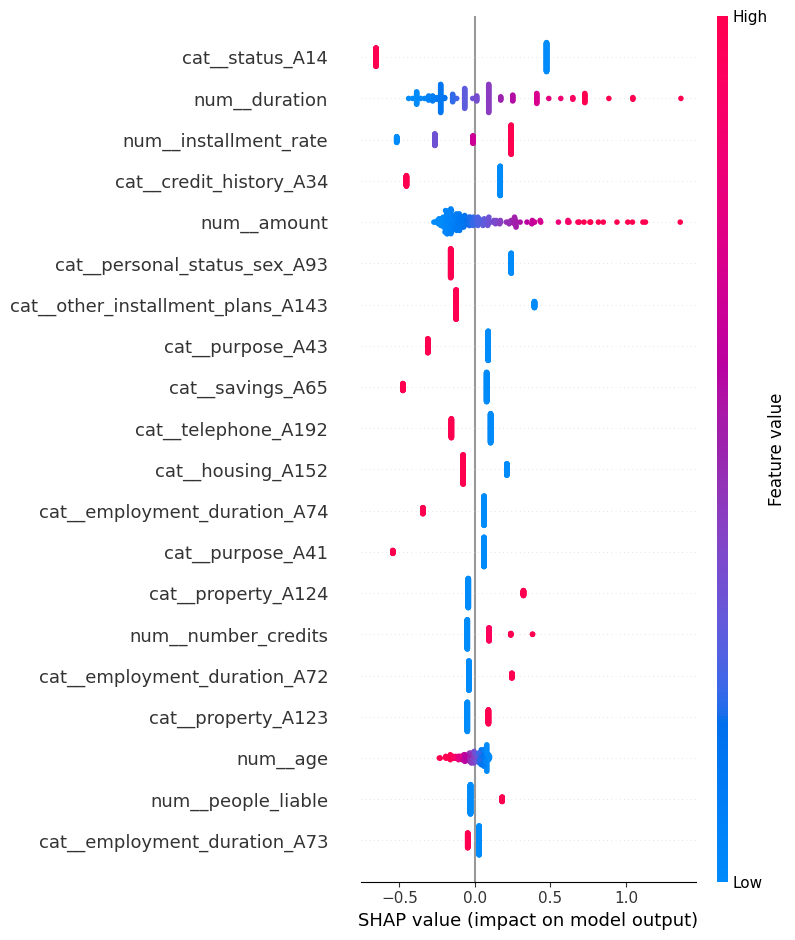

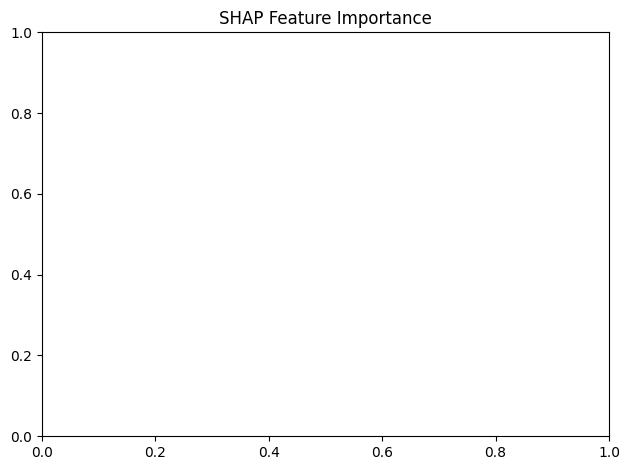

<Figure size 1200x600 with 0 Axes>

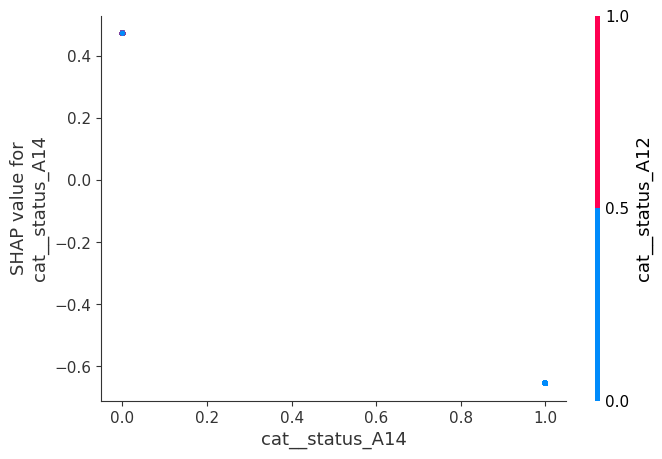

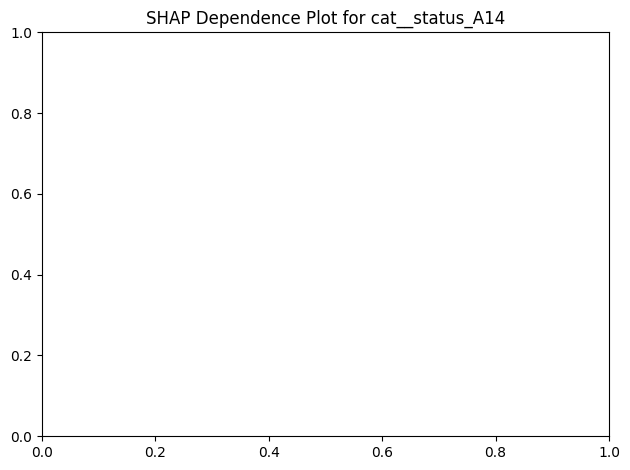

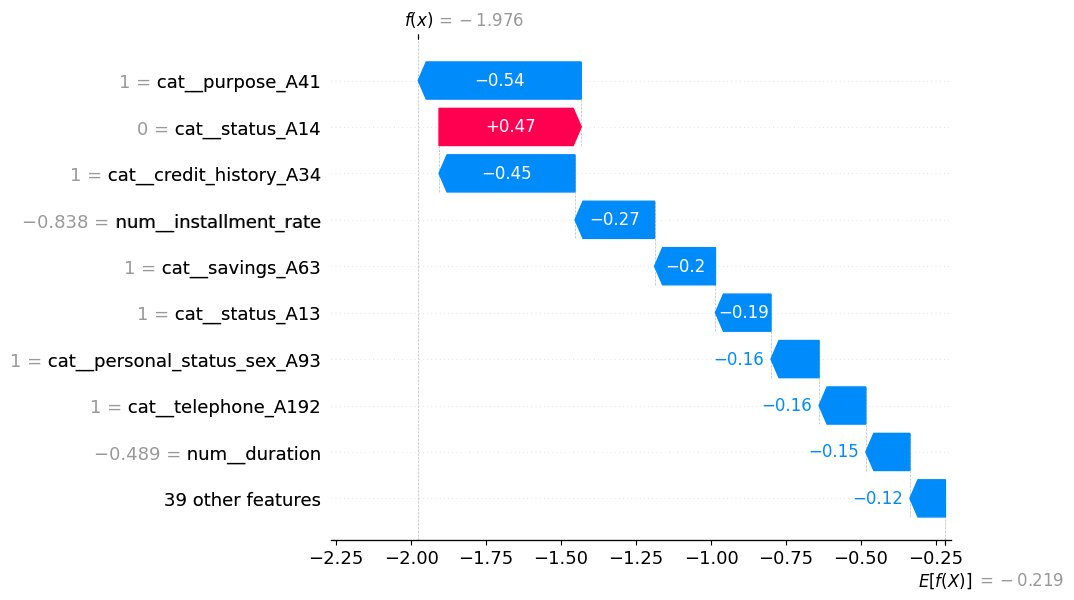

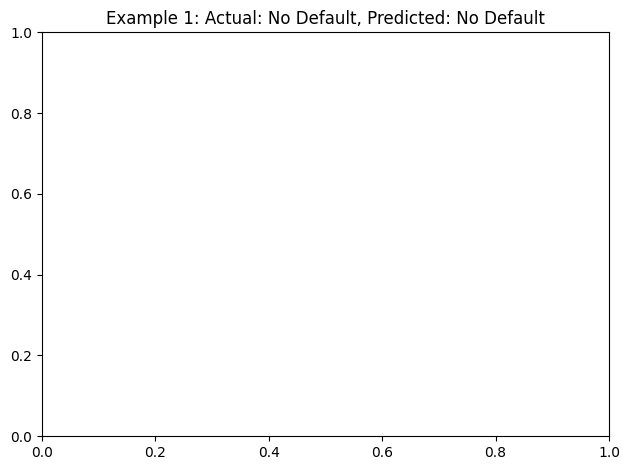

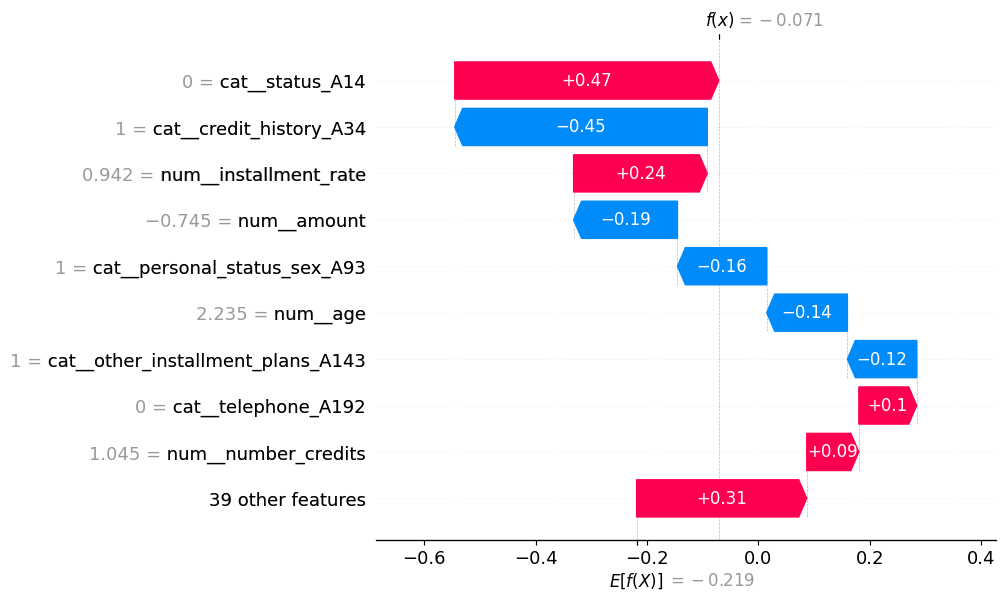

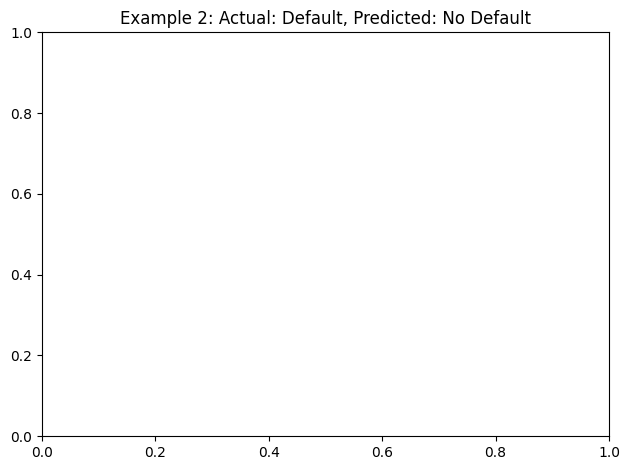

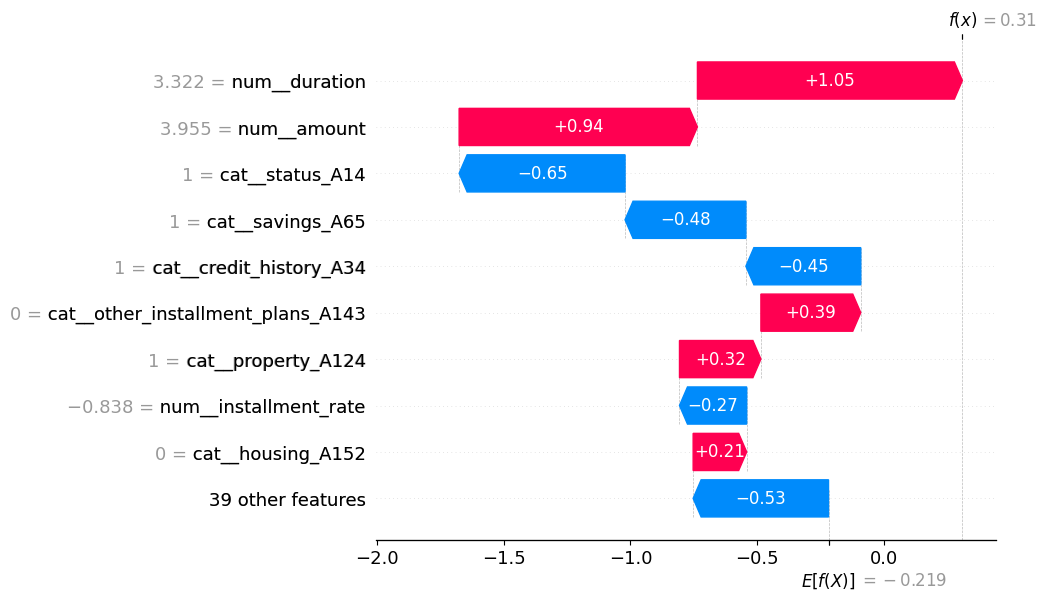

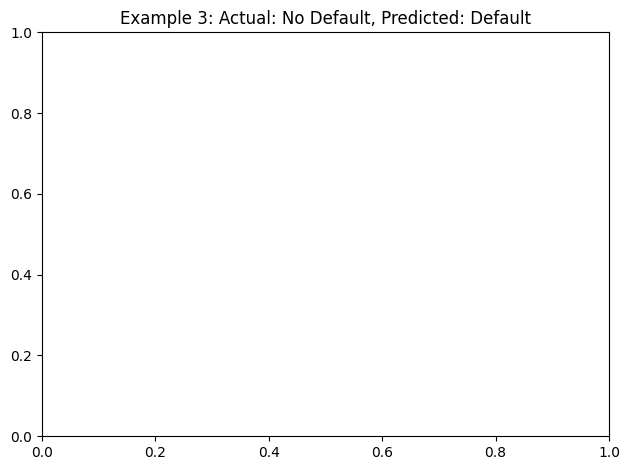

In [16]:
# Import SHAP
import shap

# Create a SHAP explainer for our logistic regression model
explainer = shap.LinearExplainer(best_lr, X_train_processed)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_processed)

# Create a SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_processed, feature_names=preprocessor.get_feature_names_out())
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# Create a SHAP dependence plot for the most important feature
# First, find the feature with the highest mean absolute SHAP value
mean_abs_shap = np.abs(shap_values).mean(0)
most_important_idx = np.argmax(mean_abs_shap)
most_important_feature = preprocessor.get_feature_names_out()[most_important_idx]

plt.figure(figsize=(12, 6))
shap.dependence_plot(most_important_idx, shap_values, X_test_processed, 
                     feature_names=preprocessor.get_feature_names_out())
plt.title(f"SHAP Dependence Plot for {most_important_feature}")
plt.tight_layout()
plt.show()

# Analyze a few example predictions to understand individual decisions
# Select a few examples from the test set
sample_indices = np.random.choice(X_test_processed.shape[0], 3, replace=False)

# Create SHAP force plots for these examples
for i, idx in enumerate(sample_indices):
    plt.figure(figsize=(12, 4))
    
    # Create a SHAP explanation object
    shap_explanation = shap.Explanation(
        values=shap_values[idx],
        base_values=explainer.expected_value,
        data=X_test_processed[idx],
        feature_names=preprocessor.get_feature_names_out().tolist()
    )
    
    # Create the force plot
    shap.plots.waterfall(shap_explanation)
    actual_class = "Default" if y_test.iloc[idx] == 1 else "No Default"
    pred_class = "Default" if best_lr.predict(X_test_processed[idx].reshape(1, -1))[0] == 1 else "No Default"
    plt.title(f"Example {i+1}: Actual: {actual_class}, Predicted: {pred_class}")
    plt.tight_layout()
    plt.show()